OPENING OF BANDS WITH RASTERIO

In [1]:
import rasterio as rio
file='20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif'
satdat=rio.open(file)
RED=satdat.read(3)
GREEN=satdat.read(2)


COMPUTATION OF NDTI AND STORING IN A TIF file

In [2]:
import numpy
numpy.seterr(divide='ignore',invalid='ignore')

NDTI=(RED.astype(float)-GREEN.astype(float))/(RED+GREEN)

meta=satdat.meta
print(meta)
NDTI_type=NDTI.dtype
print(NDTI_type)


kwargs=meta

kwargs.update(dtype=NDTI_type)
kwargs.update(count=1)
kwargs.update(driver='GTiff')

with rio.open('NDTI_PlanetScope_data/NDTIP.tif','w',**kwargs) as dst:
    dst.write(NDTI,1)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1921, 'height': 1489, 'count': 4, 'crs': CRS.from_epsg(32631), 'transform': Affine(3.0, 0.0, 176223.0,
       0.0, -3.0, 681564.0)}
float64


Class written by Joe Kington to Normalize the colorbar.

In [3]:
from matplotlib import colors

# Credit: Joe Kington
class MidpointNormalize(colors.Normalize):
    """
    Normalize the colorbar so that diverging bars work there way either side from a prescribed midpoint value
    
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return numpy.ma.masked_array(numpy.interp(value, x, y), numpy.isnan(value))

Attaining the colormap plot

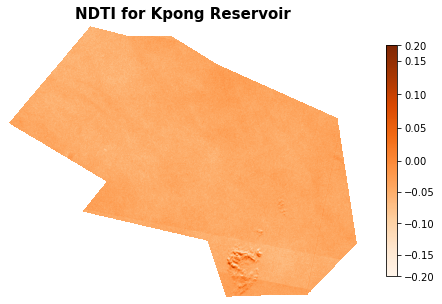

In [4]:
import matplotlib.pyplot as plt

min=numpy.nanmin(NDTI)
max=numpy.nanmax(NDTI)

mid=0.0
colormap=plt.cm.Oranges
norm= MidpointNormalize(vmin=min,vmax=max,midpoint=mid)
fig=plt.figure(figsize=(10,5))
ax=fig.add_subplot(111)
NDTI=NDTI.squeeze()
cbar_plot=ax.imshow(NDTI, cmap=colormap, norm=norm)
ax.axis('off')
cbar=fig.colorbar(cbar_plot,orientation='vertical',shrink=0.85)
ax.set_title('NDTI for Kpong Reservoir',fontsize=15,fontweight='bold')
fig.savefig("NDTI_PlanetScope_data/ndtip-fig",dpi=200,bbox_inches='tight',pad_inches=0.7)


Attaining the Histogram Plot

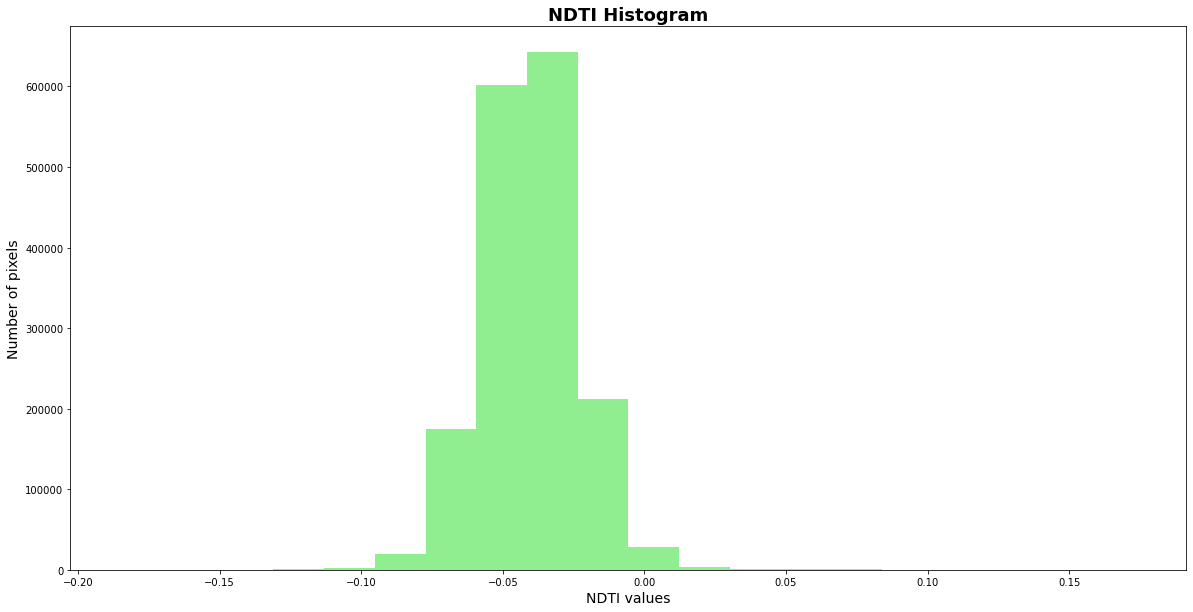

In [5]:
fig2 = plt.figure(figsize=(20,10))
ax = fig2.add_subplot(111)
plt.title("NDTI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDTI values", fontsize=14)
plt.ylabel("Number of pixels", fontsize=14)
x = NDTI[~numpy.isnan(NDTI)]
bins = 20
color = 'lightgreen'
ax.hist(x,bins,color=color)
fig2.savefig("NDTI_PlanetScope_data/ndtip-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)
plt.show()

In [6]:
fig.savefig(r"C:\xampp\htdocs\SourceCode/ndtip-fig_20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif.png", dpi=200,bbox_inches='tight',pad_inches=0.7)
fig2.savefig(r"C:\xampp\htdocs\SourceCode/ndtip-histogram_20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif.png",dpi=200,bbox_inches='tight',pad_inches=0.7)

Forwarding the Information to the Database

In [7]:
import mysql.connector
from mysql.connector import Error

In [8]:
x=0
try:
    connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

    
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("You're connected to database: ", record)
        x=x+1

except Error as e:
    print("Error while connecting to MySQL", e)


Connected to MySQL Server version  5.5.5-10.4.22-MariaDB
You're connected to database:  ('remotesensingdata',)


In [9]:
MinNDTI=float(numpy.nanmin(NDTI))
MaxNDTI=float(numpy.nanmax(NDTI))
MeanNDTI=float(numpy.nanmean(NDTI))
StdNDTI=float(numpy.nanstd(NDTI))
Id='20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif'


In [12]:
connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

cursor=connection.cursor()
cursor.execute("INSERT INTO turbidity (DatasetID, NDTIMean, NDTIMax, NDTIMin, StandardDeviation) VALUES(%s, %s, %s, %s, %s)", (Id,MeanNDTI,MaxNDTI,MinNDTI,StdNDTI))
connection.commit()
print(cursor.rowcount,"Record insert successfully in to Table")

cursor.close()

1 Record insert successfully in to Table


True

In [13]:
Id='20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif'
Figure='NDTI_PlanetScope_data/ndtip-fig.png'
Histogram='NDTI_PlanetScope_data/ndtip-histogram.png'
FigureName="ndtip-fig_20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif.png"
HistName="ndtip-histogram_20220104_110231_75_105e_3B_AnalyticMS_SR_clip.tif.png"


In [14]:
import mysql.connector
connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')

def convertToBinaryData(filename):
    with open(filename,'rb') as file:
        binaryData=file.read()
    return binaryData

In [18]:
def INSERTPIC(ID,FIG,HIST,FIGN,HISTN):
    connection=mysql.connector.connect(host='localhost',database='remotesensingdata',user='root',password='')
    C=connection.cursor()
    
    Figpic=convertToBinaryData(FIG)
    Histpic=convertToBinaryData(HIST)
    
    C.execute("INSERT INTO turbidityimages (DatasetID,NDTIfig,NDTIhistogram,NDTIFigName,NDTIHistName) VALUES(%s,%s,%s,%s,%s)",(ID,Figpic,Histpic,FIGN,HISTN))
    
    connection.commit()
    print(C.rowcount,"Record insert successfully in to Table")

    C.close()

In [19]:
INSERTPIC(Id,Figure,Histogram,FigureName,HistName)

1 Record insert successfully in to Table
